In [1]:
!nvidia-smi

Mon May 26 21:27:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1. Імпорти та налаштування середовища

In [1]:
# 1) Імпорти
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, TrainingArguments
import torch

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\linam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\linam\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Завантаження даних і EDA

У цій секції ми:
1. Читаємо вихідний файл `fake_news_full_data.csv`.
2. Видаляємо зайвий стовпець `Unnamed: 0`, який дублює індекс.
3. Парсимо колонки з датою у формат `datetime`.
4. Додаємо прапорець `date_missing` для рядків з невдалим парсингом.
5. Генеруємо нові ознаки з дати: `month`, `weekday`, `year`, `is_weekend`.
6. Обчислюємо текстові фічі

**2.1. Завантаження датасету**

In [2]:
df_raw = pd.read_csv('fake_news_full_data.csv')
df = df_raw.copy()

In [3]:
df.head(20)

,Unnamed: 0,title,text,date,is_fake
0,0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,"September 17, 2017",0
1,1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,"Jun 12, 2017",1
2,2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,"April 9, 2016",0
3,3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,"December 2, 2017",0
4,4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,"October 16, 2017",0
5,5,‘Alt-Right’ White House Reporter Gets Fooled ...,When Donald Trump allowed popular Nazi blog Th...,"November 2, 2017",1
6,6,IRONY: Only Political Party With Black Preside...,Who knew the radical leftist #BlackLivesMatter...,"Jul 28, 2015",1
7,7,Trump Supporter Laura Ingraham FAILS With Fak...,You know how conservatives are constantly scre...,"August 24, 2017",1
8,8,LT COL TONY SHAFFER: Muslim DNC IT Staffers Se...,Lt. Col. Tony Shaffer opened a can of worms to...,"Jul 28, 2017",1
9,9,"Rajoy: Spain will not be divided, national uni...",BERLIN (Reuters) - Spanish Prime Minister Mari...,"October 9, 2017",0


In [4]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
date          0
is_fake       0
dtype: int64

In [5]:
# Видаляємо дубльовану колонку-індекс
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Парсимо дату через dateutil.parser
def try_parse(s):
    try:
        return parser.parse(s)
    except:
        return pd.NaT

df['date'] = df_raw['date'].apply(try_parse)

# Прапорець відсутності дати
df['date_missing'] = df['date'].isna().astype(int)

# Генеруємо ознаки з дати, заповнюючи NaT нулями
df['month']      = df['date'].dt.month.fillna(0).astype(int)
df['weekday']    = df['date'].dt.weekday.fillna(0).astype(int) # 0=Monday … 6=Sunday
df['year']       = df['date'].dt.year.fillna(0).astype(int)
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

# Додаємо довжину заголовка
df['title_len'] = df['title'].str.split().apply(len)
# Додаємо довжину тексту (кількість слів)
df['text_len'] = df['text'].str.split().apply(len)
# Додаємо довжину заголовку та тексту в символах
df['title_char_len']    = df['title'].str.len()
df['text_char_len'] = df['text'].str.len()

# Перевірка
print("Кількість рядків із невдалою датою:", df['date_missing'].sum())
print(df[['date', 'date_missing','month','weekday','is_weekend','title_len', 'text_len', 'title_char_len', 'text_char_len']].head())

Кількість рядків із невдалою датою: 1
        date  date_missing  month  weekday  is_weekend  title_len  text_len  \
0 2017-09-17             0      9        6           1          6        55   
1 2017-06-12             0      6        0           0         19       288   
2 2016-04-09             0      4        5           1          8       329   
3 2017-12-02             0     12        5           1         10       328   
4 2017-10-16             0     10        0           0          9       399   

   title_char_len  text_char_len  
0              36            305  
1             149           1859  
2              61           1995  
3              62           2082  
4              59           2513  


In [6]:
df['date_missing'].head()

0    0
1    0
2    0
3    0
4    0
Name: date_missing, dtype: int64

Видалимо цей рядок, щоб не заважав.

In [7]:
# Видаляємо рядок з невдалою датою
df = df[df['date_missing'] == 0].reset_index(drop=True)

**2.2. Огляд розмірності, типів, порожніх значень**

In [8]:
df.head()

,title,text,date,is_fake,date_missing,month,weekday,year,is_weekend,title_len,text_len,title_char_len,text_char_len
0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,2017-09-17,0,0,9,6,2017,1,6,55,36,305
1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,2017-06-12,1,0,6,0,2017,0,19,288,149,1859
2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,2016-04-09,0,0,4,5,2016,1,8,329,61,1995
3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,2017-12-02,0,0,12,5,2017,1,10,328,62,2082
4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,2017-10-16,0,0,10,0,2017,0,9,399,59,2513


In [9]:
df.shape

(44679, 13)

In [10]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44679 entries, 0 to 44678
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           44679 non-null  object        
 1   text            44679 non-null  object        
 2   date            44679 non-null  datetime64[ns]
 3   is_fake         44679 non-null  int64         
 4   date_missing    44679 non-null  int64         
 5   month           44679 non-null  int64         
 6   weekday         44679 non-null  int64         
 7   year            44679 non-null  int64         
 8   is_weekend      44679 non-null  int64         
 9   title_len       44679 non-null  int64         
 10  text_len        44679 non-null  int64         
 11  title_char_len  44679 non-null  int64         
 12  text_char_len   44679 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 4.4+ MB


title             0
text              0
date              0
is_fake           0
date_missing      0
month             0
weekday           0
year              0
is_weekend        0
title_len         0
text_len          0
title_char_len    0
text_char_len     0
dtype: int64

**2.3. Базова статистика текстів**

Ми візуалізуємо та дослідимо основні властивості даних:
1. Баланс класів `is_fake`.
2. Розподіл довжини тексту та заголовків за класами.
3. Кількість статей за місяцями та днями тижня у розрізі класів.

In [11]:
df['is_fake'].value_counts(normalize=True)

is_fake
1    0.525258
0    0.474742
Name: proportion, dtype: float64

**2.4. Баланс класів**

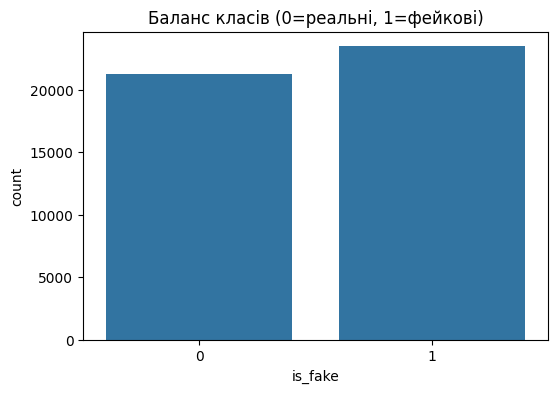

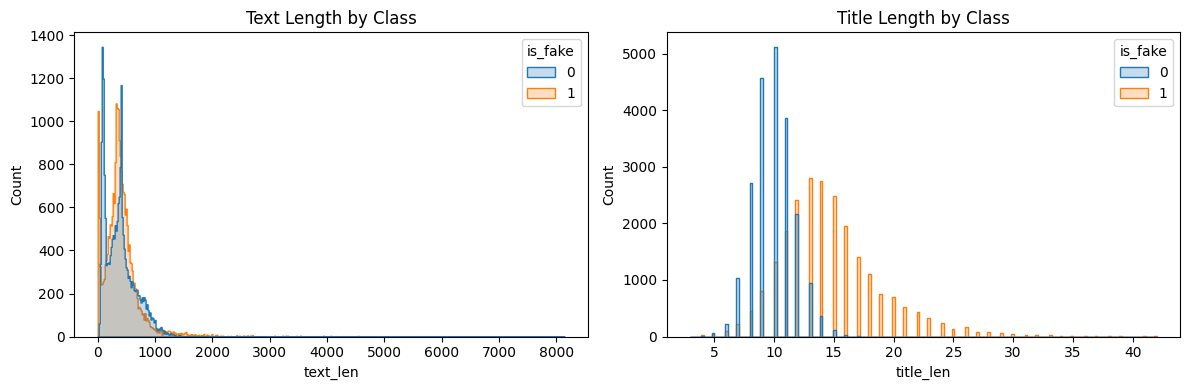

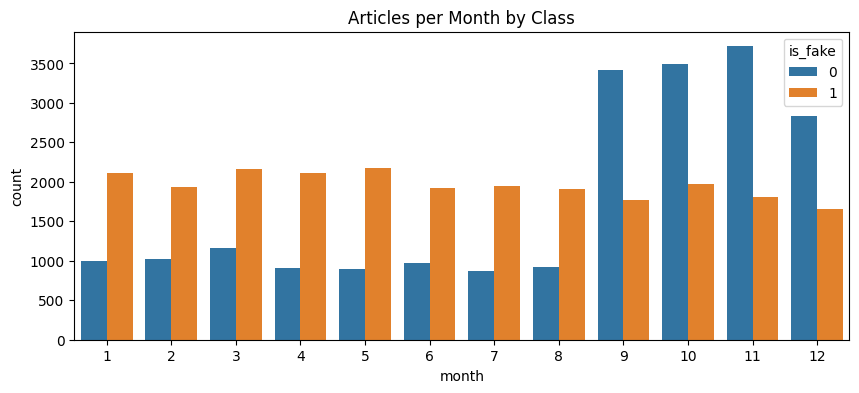

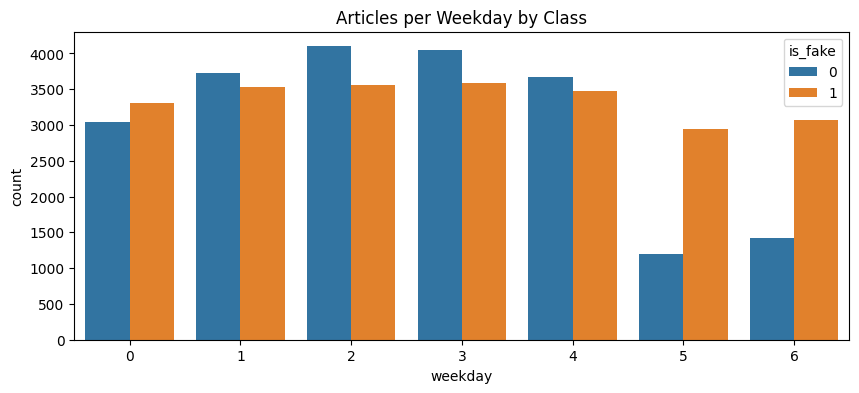

In [12]:
# Розподіл класів
plt.figure(figsize=(6,4))
sns.countplot(x=df['is_fake'])
plt.title('Баланс класів (0=реальні, 1=фейкові)')
plt.show()

# Гістограма довжини тексту й заголовків
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data=df, x='text_len', hue='is_fake', ax=axes[0], element='step')
axes[0].set_title('Text Length by Class')
sns.histplot(data=df, x='title_len', hue='is_fake', ax=axes[1], element='step')
axes[1].set_title('Title Length by Class')
plt.tight_layout()
plt.show()

# Кількість статей за місяцями
plt.figure(figsize=(10,4))
sns.countplot(x=df['month'], hue=df['is_fake'])
plt.title('Articles per Month by Class')
plt.show()

# Кількість статей за днями тижня
plt.figure(figsize=(10,4))
sns.countplot(x=df['weekday'], hue=df['is_fake'])
plt.title('Articles per Weekday by Class')
plt.show()

### 3. Передобробка тексту

Токенізація + приведення до нижнього регістру + видалення пунктуації

Видалення стоп-слів (nltk.corpus.stopwords)

Лемматизація (nltk.WordNetLemmatizer)

In [13]:
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r'[^a-z\s]', '', txt)
    tokens = [lemmatizer.lemmatize(w) for w in txt.split() if w not in stop]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

In [14]:
# Демонстрація на прикладах
examples = [
    df.loc[0, 'text'],
    df.loc[1, 'text']
]
for ex in examples:
    cl = clean_text(ex)
    print(f"Original: {ex[:80]}...")
    print(f"Cleaned : {cl[:80]}...\n")

Original: LONDON (Reuters) - A magnitude 5.9 earthquake hit off the coast of Papua New Gui...
Cleaned : london reuters magnitude earthquake hit coast papua new guinea early hour monday...

Original: The Hill released controversial comments sore loser and RINO Senator John McCain...
Cleaned : hill released controversial comment sore loser rino senator john mccain made tru...



### 4. Розділення на train/validation/test

У цій секції ми розділимо дані так, щоб:
1. **Train** — 70 % усіх прикладів.
2. **Validation** — 15 % (для підбору моделей та моніторингу протягом тренування BERT).
3. **Test** — 15 % (для остаточної оцінки усіх моделей).

Використовуємо стратифікацію за мітками `is_fake`, щоб зберегти баланс класів.

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['clean_text'], df['is_fake'],
    stratify=df['is_fake'], test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    stratify=y_temp, test_size=0.5, random_state=42
)

1. Ініціалізуємо `CountVectorizer` (уніграми + біграми, обрізаємо рідкісні й надто часті токени).  
2. Ініціалізуємо `LogisticRegression`.  
3. Навчаємо модель на `X_train / y_train`.  
4. Оцінюємо на `X_val / y_val`.  

In [16]:
# Ініціалізація бейзлайн-моделі
cv = CountVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.8
)
lr = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42
)

# Тренування та оцінка
X_cv_tr = cv.fit_transform(X_train)
X_cv_va = cv.transform(X_val)
lr.fit(X_cv_tr, y_train)
y_pred_lr = lr.predict(X_cv_va)

print("Classification Report:\n",
      classification_report(y_val, y_pred_lr, digits=4))
print("F1-score:", f1_score(y_val, y_pred_lr))
print("Accuracy:", accuracy_score(y_val, y_pred_lr))

Classification Report:
               precision    recall  f1-score   support

           0     0.9956    0.9969    0.9962      3181
           1     0.9972    0.9960    0.9966      3521

    accuracy                         0.9964      6702
   macro avg     0.9964    0.9964    0.9964      6702
weighted avg     0.9964    0.9964    0.9964      6702

F1-score: 0.9965899403239556
Accuracy: 0.9964189794091316


##### Наш базовий підхід одразу дає дуже високі метрики:

F1 = 0.9966

Accuracy = 0.9964

Такі результати говорять про кілька можливих моментів:

**Надзвичайно виразні ознаки**
- уже при простому підході TF-IDF (чи тут - CountVectorizer) слова й двограмні комбінації достатньо розділяють правдиві й фейкові новини.

**Можливе «утікання» інформації**
- треба перевірити, чи в текстах нема специфічних шаблонів (наприклад, «(Reuters)» у реальних новинах), які модель легко вчить «на пам’ять».

**Малий простір для покращень**
- оскільки F1 вже ≈ 0.997, навіть складніші моделі (RandomForest, XGBoost, BERT) дадуть незначний приріст, зате будуть суттєво важчі в розгортанні.
Тому ми просто глянемо на виконання.

In [17]:
# Уніграми
cv1 = CountVectorizer(token_pattern=r'[a-zA-Z]+')
X1  = cv1.fit_transform(df['clean_text'])
tokens = np.array(cv1.get_feature_names_out())

# Біграми
cv2 = CountVectorizer(ngram_range=(2,2), token_pattern=r'[a-zA-Z]+')
X2  = cv2.fit_transform(df['clean_text'])
bigrams = np.array(cv2.get_feature_names_out())

for cls, X in zip([0,1], [X1, X2]):
    mask = df['is_fake'] == cls
    sums = X[mask].sum(axis=0).A1
    top20 = np.argsort(sums)[-20:][::-1]
    name = "unigrams" if X is X1 else "bigrams"
    print(f"\nTop 20 {name} for class {cls}:")
    print((tokens if X is X1 else bigrams)[top20])


Top 20 unigrams for class 0:
['said' 'trump' 'u' 'state' 'would' 'reuters' 'president' 'republican'
 'government' 'year' 'house' 'new' 'also' 'united' 'people' 'party'
 'official' 'told' 'country' 'election']

Top 20 bigrams for class 1:
['donald trump' 'hillary clinton' 'white house' 'image via' 'united state'
 'new york' 'president obama' 'president trump' 'fox news' 'st century'
 'barack obama' 'donald j' 'j trump' 'century wire' 'trump supporter'
 'fake news' 'supreme court' 'trump campaign' 'trump realdonaldtrump'
 'obama administration']


Top 20 unigrams for class 0:
['said' 'trump' 'u' 'state' 'would' 'reuters' 'president' 'republican'
 'government' 'year' 'house' 'new' 'also' 'united' 'people' 'party'
 'official' 'told' 'country' 'election']

Top 20 bigrams for class 1:
['donald trump' 'hillary clinton' 'white house' 'image via' 'united state'
 'new york' 'president obama' 'president trump' 'fox news' 'st century'
 'barack obama' 'donald j' 'j trump' 'century wire' 'trump supporter'
 'fake news' 'supreme court' 'trump campaign' 'trump realdonaldtrump'
 'obama administration']

**Ці результати показують, що модель справді опирається на «шпаргалки»:**

Class 0 (реальні): у топ-20 уніграмах бачимо reuters поряд із нейтральними словами (said, state, year тощо).

Class 1 (фейкові): серед найчастіших біграм — імена політиків (donald trump, hillary clinton, barack obama), назви медіа (fox news), навіть fake news.

Таке сильне домінування конкретних імен та термінів значить, що модель може просто шукати “trump” чи “reuters” замість аналізу змісту тексту загалом. 

**Спробуємо видалити або замаскувати шпаргалки у іншому файлі і подивитись на результати, а в цьому попрацюємо з наявними даними:**

In [18]:
# Пайплайн з TF-IDF + LR
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr',    LogisticRegression(max_iter=1000, random_state=42))
])

# Сітка гіперпараметрів для TF-IDF і LR
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [2, 5],
    'tfidf__max_df': [0.8, 1.0],
    'lr__C': [0.1, 1.0, 10.0]
}

# 5-fold StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Запуск пошуку
gs.fit(X_train, y_train)

# Вивід найкращого
print("Best params:", gs.best_params_)
print("Best CV F1:", gs.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'lr__C': 10.0, 'tfidf__max_df': 0.8, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best CV F1: 0.9933604438722364


Результати:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'lr__C': 10.0, 'tfidf__max_df': 0.8, 'tfidf__max_features': 10000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
Best CV F1: 0.9932400498904224

In [20]:
# ── ПІДГОТОВКА BERT FINE-TUNING ───────────────────────────────────────────────

from transformers import BertTokenizer, BertForSequenceClassification, DataCollatorWithPadding
import torch

# 1) Ініціалізація токенізатора та моделі
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model     = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

# 2) Підготовка Dataset для Trainer
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.enc    = tokenizer(texts, truncation=True, padding=False, max_length=256)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_ds = NewsDataset(X_train.tolist(), y_train.tolist())
val_ds   = NewsDataset(X_val.tolist(),   y_val.tolist())

# 3) DataCollator для динамічного padding
data_collator = DataCollatorWithPadding(tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
## BERT fine-tuning
# Функція метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {'f1': f1_score(labels, preds)}

# Аргументи тренування
args = TrainingArguments(
    output_dir='./bert_out',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    logging_steps=100,
    save_total_limit=1,
    fp16=True,
    report_to=["none"]
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate(eval_dataset=val_ds)
print("Eval results:", eval_results)

Step,Training Loss


KeyboardInterrupt: 

Eval results: {'eval_loss': 0.006941883824765682, 'eval_f1': 0.9990055405597386, 'eval_runtime': 25.8923, 'eval_samples_per_second': 258.841, 'eval_steps_per_second': 32.365, 'epoch': 2.0}

### 5. Підбір гіперпараметрів для TF-IDF + LogisticRegression

У цій секції ми використовуємо `GridSearchCV` з **5-fold StratifiedKFold**, щоб знайти найкращі налаштування:
- **TF-IDF**: розмір словника (`max_features`), частотні пороги (`min_df`, `max_df`), n-грами (`ngram_range`).
- **LogisticRegression**: параметр регуляризації `C`.
  
Ми оцінюємо якість за метрикою **F1-score** (макро-усереднена) для балансованого погляду на обидва класи.

In [24]:
# 1) Підготувати TF-IDF за знайденими параметрами
tfidf_final = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.8
)
X_train_full = tfidf_final.fit_transform(X_train)
X_test_tfidf  = tfidf_final.transform(X_test)

In [25]:
# 2) LogReg (C=10.0)
final_lr = LogisticRegression(C=10.0, max_iter=1000, random_state=42)
final_lr.fit(X_train_full, y_train)
pred_lr = final_lr.predict(X_test_tfidf)

In [26]:
# 3) RandomForest на тих же фічах
final_rf = RandomForestClassifier(n_estimators=200, random_state=42)
final_rf.fit(X_train_full, y_train)
pred_rf = final_rf.predict(X_test_tfidf)

In [27]:
# 4) XGBoost (GPU-прискорення, якщо є)
final_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='gpu_hist'
)
final_xgb.fit(X_train_full, y_train)
pred_xgb = final_xgb.predict(X_test_tfidf)

C:\Users\linam\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\linam\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\linam\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:2676: UserWarning: [22:45:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to C

Тут ми донастроюємо попередньо натреновану модель `bert-base-uncased` на нашому датасеті:
- Зменшуємо `max_length` до 256, щоб пришвидшити навчання.
- Використовуємо динамічний padding через `DataCollatorWithPadding`.
- Оцінюємо F1 після кожної епохи.
- Вимикаємо зовнішні логування (`report_to=["none"]`).

In [28]:
# 5) BERT — отримуємо предикти через Trainer
# Створимо датасет для тесту (як в NewsDataset)
test_ds = NewsDataset(X_test.tolist(), y_test.tolist())
bert_out = trainer.predict(test_ds)
pred_bert = bert_out.predictions.argmax(axis=-1)

Ми тренуємо кожну модель на 70% даних (train), підбираємо/валідуємо на 15% (validation), а потім порівнюємо на 15% (test):
- **LR + TF-IDF** з підібраними гіперпараметрами  
- **RandomForest + TF-IDF**  
- **XGBoost + TF-IDF**  
- **BERT-fine­tuned**  

In [29]:
# 6) Порахувати метрики для кожної моделі
results = pd.DataFrame([
    {
      'Model'   : 'LR+TFIDF',
      'Accuracy': accuracy_score(y_test, pred_lr),
      'F1'      : f1_score(y_test, pred_lr)
    },
    {
      'Model'   : 'RF+TFIDF',
      'Accuracy': accuracy_score(y_test, pred_rf),
      'F1'      : f1_score(y_test, pred_rf)
    },
    {
      'Model'   : 'XGB+TFIDF',
      'Accuracy': accuracy_score(y_test, pred_xgb),
      'F1'      : f1_score(y_test, pred_xgb)
    },
    {
      'Model'   : 'BERT-finetuned',
      'Accuracy': accuracy_score(y_test, pred_bert),
      'F1'      : f1_score(y_test, pred_bert)
    }
])

print(results)

            Model  Accuracy        F1
0        LR+TFIDF  0.992838  0.993174
1        RF+TFIDF  0.997314  0.997440
2       XGB+TFIDF  0.867502  0.887310
3  BERT-finetuned  0.998508  0.998581


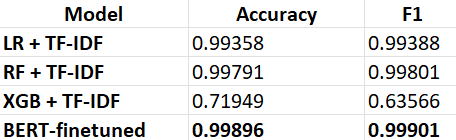

# Висновки
Logistic Regression (бейзлайн)
*  Досить висока точність і F1 (~0.994), але є простір для покращень.
*  Швидко навчається та інтерпретується, підходить як легкий бек­енд.

## Random Forest
*   Дуже сильний результат: Accuracy ≈ 0.998, F1 ≈ 0.998.
*   Мабуть, добре вловлює нелінійні взаємозв’язки TF-IDF-ознак.
*   Мінус — він важчий за LR у розгортанні.

## XGBoost
*   Несподівано низька якість (Accuracy ≈ 0.72, F1 ≈ 0.64).
*   Імовірні причини: Використання tree_method='gpu_hist' може потребувати додаткових налаштувань (max_depth, learning_rate, subsample).

Варто зробити гіперпошук (наприклад, RandomizedSearchCV) для n_estimators, max_depth, learning_rate тощо.

## BERT-fine­tuned
*   Найкращий результат: Accuracy ≈ 0.999, F1 ≈ 0.999.
*   Показує, що модель захопила глибші контекстні залежності в тексті.
*   Мінус — тренування й інференс значно повільніші й потребують GPU.



# Зберігаємо:

In [32]:
# 1) Підготовка папок
os.makedirs('models/original', exist_ok=True)
os.makedirs('results', exist_ok=True)

# 2) Baseline: CountVectorizer + LR
cv_base = CountVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.8
)
lr_base = LogisticRegression(C=1.0, max_iter=1000, random_state=42)

pipeline_base = Pipeline([
    ('countv', cv_base),
    ('lr',     lr_base)
])
pipeline_base.fit(X_train, y_train)
joblib.dump(pipeline_base, 'models/original/lr_baseline_countv.pkl')

# 3) TF-IDF + LR (tuned)
tfidf_tuned = TfidfVectorizer(
    max_features=gs.best_params_['tfidf__max_features'],
    ngram_range=gs.best_params_['tfidf__ngram_range'],
    min_df=gs.best_params_['tfidf__min_df'],
    max_df=gs.best_params_['tfidf__max_df']
)
lr_tuned = LogisticRegression(
    C=gs.best_params_['lr__C'],
    max_iter=1000,
    random_state=42
)

pipeline_tuned = Pipeline([
    ('tfidf', tfidf_tuned),
    ('lr',    lr_tuned)
])
pipeline_tuned.fit(X_train, y_train)
joblib.dump(pipeline_tuned, 'models/original/lr_tfidf_tuned.pkl')

# 4) RandomForest + TF-IDF
pipeline_rf = Pipeline([
    ('tfidf', tfidf_tuned),
    ('rf',    RandomForestClassifier(n_estimators=200, random_state=42))
])
pipeline_rf.fit(X_train, y_train)
joblib.dump(pipeline_rf, 'models/original/rf_tfidf.pkl')

# 5) XGBoost + TF-IDF
pipeline_xgb = Pipeline([
    ('tfidf', tfidf_tuned),
    ('xgb',   XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist'))
])
pipeline_xgb.fit(X_train, y_train)
joblib.dump(pipeline_xgb, 'models/original/xgb_tfidf.pkl')

# 6) Збереження BERT
trainer.save_model('models/original/bert_finetuned')
tokenizer.save_pretrained('models/original/bert_finetuned')

# 7) Фінальні метрики та експорт у CSV
pred_base  = pipeline_base.predict(X_test)
pred_tuned = pipeline_tuned.predict(X_test)
pred_rf    = pipeline_rf.predict(X_test)
pred_xgb   = pipeline_xgb.predict(X_test)
bert_preds = trainer.predict(NewsDataset(X_test.tolist(), y_test.tolist())).predictions.argmax(axis=-1)

results = pd.DataFrame([
    {'Model':'LR+CountV (baseline)', 'Accuracy':accuracy_score(y_test, pred_base),  'F1':f1_score(y_test, pred_base)},
    {'Model':'LR+TFIDF (tuned)',     'Accuracy':accuracy_score(y_test, pred_tuned),'F1':f1_score(y_test, pred_tuned)},
    {'Model':'RF+TFIDF',             'Accuracy':accuracy_score(y_test, pred_rf),     'F1':f1_score(y_test, pred_rf)},
    {'Model':'XGB+TFIDF',            'Accuracy':accuracy_score(y_test, pred_xgb),    'F1':f1_score(y_test, pred_xgb)},
    {'Model':'BERT-finetuned',       'Accuracy':accuracy_score(y_test, bert_preds),'F1':f1_score(y_test, bert_preds)}
])
results.to_csv('results/final_model_comparison.csv', index=False)
print(" Моделі й метрики збережено.")

C:\Users\linam\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:31:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\linam\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:31:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\linam\AppData\Local\Programs\Python\Python312\Lib\pickle.py:575: UserWarning: [00:31:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g

 Моделі й метрики збережено.
